In [1]:
#!pip install -U flwr["simulation"]==1.9.0 torch torchvision GPUtil

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR100
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [2]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 107.5 GB  | Proc size: 511.9 MB
GPU RAM Free: 13368MB | Used: 2802MB | Util  17% | Total 16376MB


In [4]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR100("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR100("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [7]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [8]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [9]:
strategy = FedCustom()

In [ ]:
#strategy = FedCustom()
#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-29 16:16:46,417	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 73780756685.0, 'accelerator_type:RTX': 1.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'object_store_memory': 35906038579.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32004) [Client 3] evaluate, config: {}
(ClientAppActor pid=32004) Epoch 9: train loss 0.103435, accuracy 0.192000 [repeated 2x across cluster]
(ClientAppActor pid=32004) Training time for Client 6: 24.08 seconds
(ClientAppActor pid=27316) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 24.075904846191406and 2habhhahah
this is tehb mode time [24.08]
This is ths last time not a fantasy 22.77273917198181and 7habhhahah
this is tehb mode time [24.08, 22.77]
This is ths last time not a fantasy 22.752891778945923and 1habhhahah
this is tehb mode time [24.08, 22.77, 22.75]
This is ths last time not a fantasy 22.744811296463013and 0habhhahah
this is tehb mode time [24.08, 22.77, 22.75, 22.74]
This is ths last time not a fantasy 23.072978496551514and 4habhhahah
this is tehb mode time [24.08, 22.77, 22.75, 22.74, 23.07]
This is ths last time not a fantasy 22.979236841201782and 9habhhahah
this is tehb mode time [24.08, 22.77, 22.75, 22.74, 23.07, 22.98]
This is ths last time not a fantasy 23.036785125732422and 3habhhahah
this is tehb mode time [24.08, 22.77, 22.75, 22.74, 23.07, 22.98, 23.04]
This is ths last time not a fantasy 22.58278179168701and 8habhhahah
this is tehb mode time [24.08, 22.77, 22.75, 22.74, 23.07, 22.98, 23.04, 22.58]
This i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32004) [Client 1] evaluate, config: {}
(ClientAppActor pid=32004) Training time for Client 5: 24.48 seconds
(ClientAppActor pid=32004) Epoch 9: train loss 0.076680, accuracy 0.359111
(ClientAppActor pid=10196) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29928) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.252203702926636and 1habhhahah
this is tehb mode time [22.25]
This is ths last time not a fantasy 22.0602068901062and 0habhhahah
this is tehb mode time [22.25, 22.06]
This is ths last time not a fantasy 22.925323009490967and 2habhhahah
this is tehb mode time [22.25, 22.06, 22.93]
This is ths last time not a fantasy 24.475764751434326and 5habhhahah
this is tehb mode time [22.25, 22.06, 22.93, 24.48]
This is ths last time not a fantasy 23.093482494354248and 7habhhahah
this is tehb mode time [22.25, 22.06, 22.93, 24.48, 23.09]
This is ths last time not a fantasy 21.398250341415405and 6habhhahah
this is tehb mode time [22.25, 22.06, 22.93, 24.48, 23.09, 21.4]
This is ths last time not a fantasy 22.665659427642822and 3habhhahah
this is tehb mode time [22.25, 22.06, 22.93, 24.48, 23.09, 21.4, 22.67]
This is ths last time not a fantasy 22.435072422027588and 8habhhahah
this is tehb mode time [22.25, 22.06, 22.93, 24.48, 23.09, 21.4, 22.67, 22.44]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1348) Epoch 9: train loss 0.053468, accuracy 0.524222 [repeated 4x across cluster]
(ClientAppActor pid=1348) [Client 3] evaluate, config: {}
(ClientAppActor pid=1348) Training time for Client 4: 23.58 seconds
(ClientAppActor pid=33476) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.328879594802856and 9habhhahah
this is tehb mode time [21.33]
This is ths last time not a fantasy 19.93148159980774and 8habhhahah
this is tehb mode time [21.33, 19.93]
This is ths last time not a fantasy 20.046860218048096and 2habhhahah
this is tehb mode time [21.33, 19.93, 20.05]
This is ths last time not a fantasy 22.62030863761902and 6habhhahah
this is tehb mode time [21.33, 19.93, 20.05, 22.62]
This is ths last time not a fantasy 20.49226450920105and 5habhhahah
this is tehb mode time [21.33, 19.93, 20.05, 22.62, 20.49]
This is ths last time not a fantasy 23.577876806259155and 4habhhahah
this is tehb mode time [21.33, 19.93, 20.05, 22.62, 20.49, 23.58]
This is ths last time not a fantasy 20.653747081756592and 0habhhahah
this is tehb mode time [21.33, 19.93, 20.05, 22.62, 20.49, 23.58, 20.65]
This is ths last time not a fantasy 20.451472282409668and 7habhhahah
this is tehb mode time [21.33, 19.93, 20.05, 22.62, 20.49, 23.58, 20.65, 20.45]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29928) [Client 2] evaluate, config: {}
(ClientAppActor pid=29928) Epoch 8: train loss 0.046650, accuracy 0.568667 [repeated 2x across cluster]
(ClientAppActor pid=29928) Training time for Client 3: 21.28 seconds
(ClientAppActor pid=41044) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=10196) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.567246198654175and 1habhhahah
this is tehb mode time [21.57]
This is ths last time not a fantasy 20.132389307022095and 4habhhahah
this is tehb mode time [21.57, 20.13]
This is ths last time not a fantasy 21.27581763267517and 3habhhahah
this is tehb mode time [21.57, 20.13, 21.28]
This is ths last time not a fantasy 20.30633854866028and 7habhhahah
this is tehb mode time [21.57, 20.13, 21.28, 20.31]
This is ths last time not a fantasy 20.084178686141968and 5habhhahah
this is tehb mode time [21.57, 20.13, 21.28, 20.31, 20.08]
This is ths last time not a fantasy 20.47616219520569and 2habhhahah
this is tehb mode time [21.57, 20.13, 21.28, 20.31, 20.08, 20.48]
This is ths last time not a fantasy 20.243427276611328and 9habhhahah
this is tehb mode time [21.57, 20.13, 21.28, 20.31, 20.08, 20.48, 20.24]
This is ths last time not a fantasy 19.952813863754272and 0habhhahah
this is tehb mode time [21.57, 20.13, 21.28, 20.31, 20.08, 20.48, 20.24, 19.95]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29928) [Client 9] evaluate, config: {}
(ClientAppActor pid=29928) Epoch 8: train loss 0.034792, accuracy 0.686000 [repeated 3x across cluster]
(ClientAppActor pid=29928) Training time for Client 6: 21.63 seconds
(ClientAppActor pid=33476) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=10196) [Client 4] evaluate, config: {} [repeated 5x across cluster]
This is ths last time not a fantasy 20.42597222328186and 0habhhahah
this is tehb mode time [20.43]
This is ths last time not a fantasy 20.50934886932373and 4habhhahah
this is tehb mode time [20.43, 20.51]
This is ths last time not a fantasy 20.54240846633911and 2habhhahah
this is tehb mode time [20.43, 20.51, 20.54]
This is ths last time not a fantasy 20.351478576660156and 9habhhahah
this is tehb mode time [20.43, 20.51, 20.54, 20.35]
This is ths last time not a fantasy 20.894161462783813and 1habhhahah
this is tehb mode time [20.43, 20.51, 20.54, 20.35, 20.89]
This is ths last time not a fantasy 20.366726398468018and 7habhhahah
this is tehb mode time [20.43, 20.51, 20.54, 20.35, 20.89, 20.37]
This is ths last time not a fantasy 20.26914691925049and 5habhhahah
this is tehb mode time [20.43, 20.51, 20.54, 20.35, 20.89, 20.37, 20.27]
This is ths last time not a fantasy 20.44709014892578and 3habhhahah
t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29928) [Client 6] evaluate, config: {}
(ClientAppActor pid=29928) Epoch 8: train loss 0.027417, accuracy 0.748222 [repeated 2x across cluster]
(ClientAppActor pid=29928) Training time for Client 8: 20.96 seconds
(ClientAppActor pid=27316) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.61058783531189and 7habhhahah
this is tehb mode time [19.61]
This is ths last time not a fantasy 20.769683599472046and 0habhhahah
this is tehb mode time [19.61, 20.77]
This is ths last time not a fantasy 20.075117349624634and 1habhhahah
this is tehb mode time [19.61, 20.77, 20.08]
This is ths last time not a fantasy 20.589473962783813and 9habhhahah
this is tehb mode time [19.61, 20.77, 20.08, 20.59]
This is ths last time not a fantasy 20.96489429473877and 8habhhahah
this is tehb mode time [19.61, 20.77, 20.08, 20.59, 20.96]
This is ths last time not a fantasy 20.203514337539673and 3habhhahah
this is tehb mode time [19.61, 20.77, 20.08, 20.59, 20.96, 20.2]
This is ths last time not a fantasy 21.73711085319519and 6habhhahah
this is tehb mode time [19.61, 20.77, 20.08, 20.59, 20.96, 20.2, 21.74]
This is ths last time not a fantasy 20.61037039756775and 4habhhahah
this is tehb mode time [19.61, 20.77, 20.08, 20.59, 20.96, 20.2, 21.74, 20.61]
This is ths

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39824) Epoch 8: train loss 0.022236, accuracy 0.795333 [repeated 4x across cluster]
(ClientAppActor pid=39824) [Client 3] evaluate, config: {}
(ClientAppActor pid=39824) Training time for Client 5: 21.80 seconds
(ClientAppActor pid=10196) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.340224027633667and 3habhhahah
this is tehb mode time [20.34]
This is ths last time not a fantasy 20.333532333374023and 9habhhahah
this is tehb mode time [20.34, 20.33]
This is ths last time not a fantasy 20.167219161987305and 4habhhahah
this is tehb mode time [20.34, 20.33, 20.17]
This is ths last time not a fantasy 20.391361951828003and 0habhhahah
this is tehb mode time [20.34, 20.33, 20.17, 20.39]
This is ths last time not a fantasy 20.416293382644653and 8habhhahah
this is tehb mode time [20.34, 20.33, 20.17, 20.39, 20.42]
This is ths last time not a fantasy 21.795608043670654and 5habhhahah
this is tehb mode time [20.34, 20.33, 20.17, 20.39, 20.42, 21.8]
This is ths last time not a fantasy 20.979363441467285and 7habhhahah
this is tehb mode time [20.34, 20.33, 20.17, 20.39, 20.42, 21.8, 20.98]
This is ths last time not a fantasy 20.18132519721985and 6habhhahah
this is tehb mode time [20.34, 20.33, 20.17, 20.39, 20.42, 21.8, 20.98, 20.18]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=10196) [Client 2] evaluate, config: {}
(ClientAppActor pid=10196) Epoch 8: train loss 0.019102, accuracy 0.825111 [repeated 2x across cluster]
(ClientAppActor pid=10196) Training time for Client 2: 21.79 seconds
(ClientAppActor pid=32004) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.40288281440735and 9habhhahah
this is tehb mode time [20.4]
This is ths last time not a fantasy 21.79383420944214and 2habhhahah
this is tehb mode time [20.4, 21.79]
This is ths last time not a fantasy 20.62409996986389and 8habhhahah
this is tehb mode time [20.4, 21.79, 20.62]
This is ths last time not a fantasy 22.43338894844055and 4habhhahah
this is tehb mode time [20.4, 21.79, 20.62, 22.43]
This is ths last time not a fantasy 21.259923458099365and 1habhhahah
this is tehb mode time [20.4, 21.79, 20.62, 22.43, 21.26]
This is ths last time not a fantasy 19.952463626861572and 7habhhahah
this is tehb mode time [20.4, 21.79, 20.62, 22.43, 21.26, 19.95]
This is ths last time not a fantasy 20.937923908233643and 3habhhahah
this is tehb mode time [20.4, 21.79, 20.62, 22.43, 21.26, 19.95, 20.94]
This is ths last time not a fantasy 20.228585243225098and 0habhhahah
this is tehb mode time [20.4, 21.79, 20.62, 22.43, 21.26, 19.95, 20.94, 20.23]
This is ths last

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1348) [Client 9] evaluate, config: {}
(ClientAppActor pid=1348) Epoch 8: train loss 0.016204, accuracy 0.857556 [repeated 2x across cluster]
(ClientAppActor pid=1348) Training time for Client 6: 21.61 seconds
(ClientAppActor pid=27316) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.955970764160156and 1habhhahah
this is tehb mode time [19.96]
This is ths last time not a fantasy 20.18747639656067and 7habhhahah
this is tehb mode time [19.96, 20.19]
This is ths last time not a fantasy 19.75996971130371and 4habhhahah
this is tehb mode time [19.96, 20.19, 19.76]
This is ths last time not a fantasy 21.606916904449463and 5habhhahah
this is tehb mode time [19.96, 20.19, 19.76, 21.61]
This is ths last time not a fantasy 20.19554090499878and 0habhhahah
this is tehb mode time [19.96, 20.19, 19.76, 21.61, 20.2]
This is ths last time not a fantasy 21.609935760498047and 6habhhahah
this is tehb mode time [19.96, 20.19, 19.76, 21.61, 20.2, 21.61]
This is ths last time not a fantasy 20.59658432006836and 9habhhahah
this is tehb mode time [19.96, 20.19, 19.76, 21.61, 20.2, 21.61, 20.6]
This is ths last time not a fantasy 20.098305225372314and 2habhhahah
this is tehb mode time [19.96, 20.19, 19.76, 21.61, 20.2, 21.61, 20.6, 20.1]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1348) [Client 9] evaluate, config: {}
(ClientAppActor pid=1348) Training time for Client 3: 23.97 seconds
(ClientAppActor pid=1348) Epoch 9: train loss 0.011799, accuracy 0.900000
(ClientAppActor pid=39824) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 611.08s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.13620855560302733
INFO :      		round 2: 0.11030682291984557
INFO :      		round 3: 0.11146241488456725
INFO :      		round 4: 0.11751258034706116
INFO :      		round 5: 0.12816300563812255
INFO :      		round 6: 0.13819476838111877
INFO :      		round 7: 0.14839529104232788
INFO :      		round 8: 0.15924640221595765
INFO :      		round 9: 0.16633188962936402
INFO :      		round 10: 0.1830702877998352
INFO :      


History (loss, distributed):
	round 1: 0.13620855560302733
	round 2: 0.11030682291984557
	round 3: 0.11146241488456725
	round 4: 0.11751258034706116
	round 5: 0.12816300563812255
	round 6: 0.13819476838111877
	round 7: 0.14839529104232788
	round 8: 0.15924640221595765
	round 9: 0.16633188962936402
	round 10: 0.1830702877998352

C:\Users\Admin\AppData\Local\Temp\ipykernel_28844\424450427.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,ncol= 2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_28844\424450427.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc='lower right',fontsize='x-small', shadow=True, ncol=2)


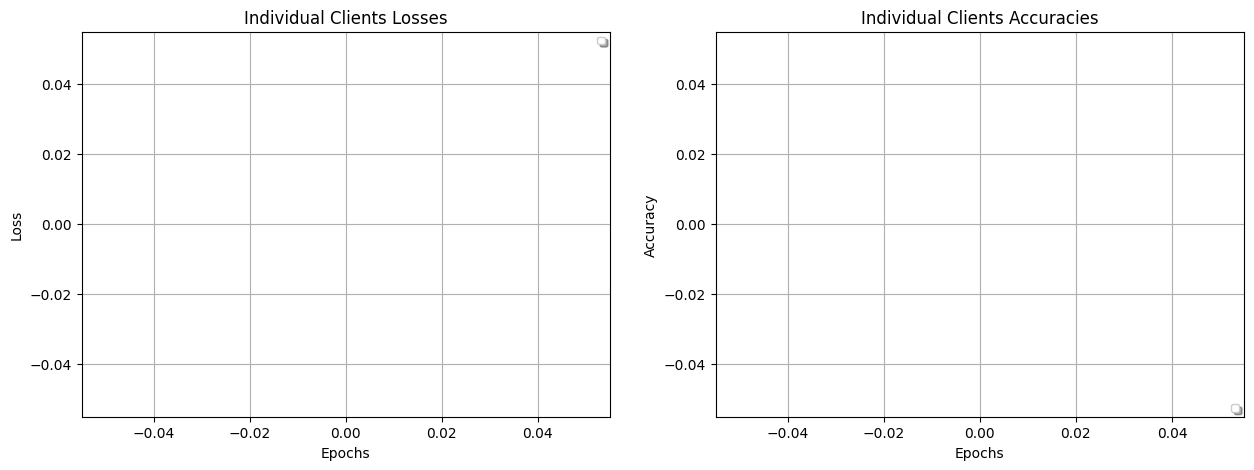

In [10]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,ncol= 2)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True, ncol=2)
    axs[1].grid()

    plt.show()

plot_metrics(strategy.client_metrics)

In [12]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    client_ids.sort()
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Rounds")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Individual Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend(loc='upper right', fontsize='x-small', shadow=True, ncol=len(client_ids))

    plt.show()

#plot_times(strategy.client_training_times)

In [13]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 0 metrics: 93
Client 8 metrics: 93
Client 2 metrics: 93
Client 5 metrics: 94
Client 1 metrics: 93
Client 3 metrics: 93
Client 9 metrics: 93
Client 7 metrics: 93
Client 4 metrics: 95
Client 6 metrics: 93


In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [15]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [16]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-29 16:27:09,421	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 35977758720.0, 'node:127.0.0.1': 1.0, 'memory': 73948103680.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20888) [Client 2] get_parameters
(ClientAppActor pid=20888) [Client 1] fit, config: {}
(ClientAppActor pid=20888) Epoch 0: train loss 0.140541, accuracy 0.025333
(ClientAppActor pid=20888) Epoch 1: train loss 0.131099, accuracy 0.050889
(ClientAppActor pid=37740) [Client 8] fit, config: {}
(ClientAppActor pid=20888) Epoch 2: train loss 0.125707, accuracy 0.075778
(ClientAppActor pid=43376) [Client 3] fit, config: {}
(ClientAppActor pid=37740) Epoch 0: train loss 0.140863, accuracy 0.022444
(ClientAppActor pid=40512) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=40512) Epoch 0: train loss 0.141276, accuracy 0.022222 [repeated 10x across cluster]
(ClientAppActor pid=27700) [Client 9] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=27700) Epoch 1: train loss 0.130907, accuracy 0.056889 [repeated 17x across cluster]
(ClientAppActor pid=20888) [Client 2] fit, config: {}
(ClientAppActor pid=24780) Epoch 4: train loss 0.118772

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37740) Epoch 9: train loss 0.104659, accuracy 0.184000 [repeated 3x across cluster]
(ClientAppActor pid=37740) [Client 9] evaluate, config: {}
(ClientAppActor pid=37740) Client 9 loss 0.13794217014312743
(ClientAppActor pid=37740) Client 9 accuracy 0.08
(ClientAppActor pid=27700) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27700) Client 0 loss 0.13748360538482665 [repeated 4x across cluster]
(ClientAppActor pid=27700) Client 0 accuracy 0.07 [repeated 4x across cluster]
(ClientAppActor pid=37740) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37740) Client 2 loss 0.1374947052001953 [repeated 4x across cluster]
(ClientAppActor pid=37740) Client 2 accuracy 0.046 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37288) [Client 3] fit, config: {}
(ClientAppActor pid=37288) [Client 7] evaluate, config: {}
(ClientAppActor pid=37288) Client 7 loss 0.13676608943939209
(ClientAppActor pid=37288) Client 7 accuracy 0.056
(ClientAppActor pid=37288) Epoch 0: train loss 0.123271, accuracy 0.099111
(ClientAppActor pid=27700) [Client 7] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=37740) Epoch 2: train loss 0.110840, accuracy 0.154667 [repeated 12x across cluster]
(ClientAppActor pid=43376) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=40512) Epoch 5: train loss 0.099737, accuracy 0.212000 [repeated 20x across cluster]
(ClientAppActor pid=37740) Epoch 7: train loss 0.089641, accuracy 0.268444 [repeated 20x across cluster]
(ClientAppActor pid=37288) [Client 8] fit, config: {}
(ClientAppActor pid=13620) Epoch 7: train loss 0.089212, accuracy 0.276889 [repeated 18x across cluster]
(ClientAppActor pid=40512) [Client 5] fit, config: {}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40512) Epoch 9: train loss 0.079096, accuracy 0.347778 [repeated 5x across cluster]
(ClientAppActor pid=40512) [Client 1] evaluate, config: {}
(ClientAppActor pid=40512) Client 1 loss 0.10765480756759643
(ClientAppActor pid=40512) Client 1 accuracy 0.21
(ClientAppActor pid=13620) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=13620) Client 8 loss 0.11096466875076294 [repeated 4x across cluster]
(ClientAppActor pid=13620) Client 8 accuracy 0.196 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37288) [Client 9] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 9 loss 0.11564257097244263 [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 9 accuracy 0.16 [repeated 5x across cluster]
(ClientAppActor pid=37288) [Client 2] fit, config: {}
(ClientAppActor pid=37288) Epoch 0: train loss 0.107311, accuracy 0.172444
(ClientAppActor pid=24780) [Client 0] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=40512) Epoch 0: train loss 0.106862, accuracy 0.179556 [repeated 11x across cluster]
(ClientAppActor pid=13620) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=37288) Epoch 5: train loss 0.077718, accuracy 0.344889 [repeated 18x across cluster]
(ClientAppActor pid=27700) Epoch 6: train loss 0.073552, accuracy 0.386000 [repeated 19x across cluster]
(ClientAppActor pid=37288) [Client 7] fit, config: {}
(ClientAppActor pid=37740) Epoch 9: train loss 0.057029, accuracy 0.491556 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37740) Epoch 9: train loss 0.057129, accuracy 0.498667 [repeated 5x across cluster]
(ClientAppActor pid=37740) [Client 9] evaluate, config: {}
(ClientAppActor pid=37740) Client 9 loss 0.12006469631195069
(ClientAppActor pid=37740) Client 9 accuracy 0.196
(ClientAppActor pid=40512) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=37740) Client 2 loss 0.11118388748168945 [repeated 4x across cluster]
(ClientAppActor pid=37740) Client 2 accuracy 0.216 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37288) [Client 5] fit, config: {}
(ClientAppActor pid=37288) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37288) Client 3 loss 0.10944198942184448 [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 3 accuracy 0.202 [repeated 5x across cluster]
(ClientAppActor pid=37288) Epoch 0: train loss 0.100498, accuracy 0.229333
(ClientAppActor pid=40512) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=13620) Epoch 0: train loss 0.100874, accuracy 0.214444 [repeated 11x across cluster]
(ClientAppActor pid=43376) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27700) Epoch 3: train loss 0.075464, accuracy 0.372222 [repeated 17x across cluster]
(ClientAppActor pid=37288) Epoch 7: train loss 0.049729, accuracy 0.562222 [repeated 19x across cluster]
(ClientAppActor pid=40512) Epoch 8: train loss 0.045534, accuracy 0.582889 [repeated 16x across cluster]
(ClientAppActor pid=37288) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20888) [Client 8] evaluate, config: {}
(ClientAppActor pid=20888) Client 8 loss 0.11874985742568969
(ClientAppActor pid=20888) Client 8 accuracy 0.192
(ClientAppActor pid=20888) Epoch 9: train loss 0.038373, accuracy 0.649778 [repeated 2x across cluster]
(ClientAppActor pid=27700) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13620) Client 5 loss 0.116074049949646 [repeated 4x across cluster]
(ClientAppActor pid=13620) Client 5 accuracy 0.244 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37288) [Client 1] fit, config: {}
(ClientAppActor pid=37288) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37288) Client 1 loss 0.11606158590316773 [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 1 accuracy 0.252 [repeated 5x across cluster]
(ClientAppActor pid=37288) Epoch 0: train loss 0.096905, accuracy 0.241778
(ClientAppActor pid=40512) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=13620) Epoch 1: train loss 0.083372, accuracy 0.318000 [repeated 11x across cluster]
(ClientAppActor pid=27700) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=24780) Epoch 4: train loss 0.056782, accuracy 0.496222 [repeated 17x across cluster]
(ClientAppActor pid=37288) Epoch 7: train loss 0.037077, accuracy 0.665556 [repeated 19x across cluster]
(ClientAppActor pid=37288) Epoch 9: train loss 0.027292, accuracy 0.754222 [repeated 16x across cluster]
(ClientAppActor pid=37288) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20888) [Client 6] evaluate, config: {}
(ClientAppActor pid=20888) Client 6 loss 0.13716968965530396
(ClientAppActor pid=20888) Client 6 accuracy 0.21
(ClientAppActor pid=20888) Epoch 9: train loss 0.029673, accuracy 0.729778 [repeated 2x across cluster]
(ClientAppActor pid=37740) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37740) Client 4 loss 0.14095364999771118 [repeated 4x across cluster]
(ClientAppActor pid=37740) Client 4 accuracy 0.224 [repeated 4x across cluster]
(ClientAppActor pid=24780) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37288) [Client 1] fit, config: {}
(ClientAppActor pid=37288) Client 9 loss 0.14289187431335448 [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 9 accuracy 0.214 [repeated 5x across cluster]
(ClientAppActor pid=37288) [Client 9] evaluate, config: {}
(ClientAppActor pid=37288) Epoch 0: train loss 0.096446, accuracy 0.258444
(ClientAppActor pid=24780) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=24780) Epoch 1: train loss 0.079240, accuracy 0.343556 [repeated 10x across cluster]
(ClientAppActor pid=43376) [Client 5] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=40512) Epoch 4: train loss 0.049206, accuracy 0.566889 [repeated 18x across cluster]
(ClientAppActor pid=13620) Epoch 7: train loss 0.031486, accuracy 0.711111 [repeated 20x across cluster]
(ClientAppActor pid=37288) [Client 8] fit, config: {}
(ClientAppActor pid=24780) Epoch 8: train loss 0.026340, accuracy 0.758222 [repeated 18x across cluster]
(C

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13620) [Client 0] evaluate, config: {}
(ClientAppActor pid=13620) Client 0 loss 0.1335408549308777
(ClientAppActor pid=13620) Client 0 accuracy 0.242
(ClientAppActor pid=13620) Epoch 9: train loss 0.021910, accuracy 0.800000
(ClientAppActor pid=27700) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=27700) Client 1 loss 0.1344707565307617 [repeated 4x across cluster]
(ClientAppActor pid=27700) Client 1 accuracy 0.262 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=37288) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37288) Client 6 loss 0.15059561824798584 [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 6 accuracy 0.202 [repeated 5x across cluster]
(ClientAppActor pid=37288) [Client 2] fit, config: {}
(ClientAppActor pid=37288) Epoch 0: train loss 0.097689, accuracy 0.249778
(ClientAppActor pid=13620) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=13620) Epoch 0: train loss 0.097709, accuracy 0.254889 [repeated 11x across cluster]
(ClientAppActor pid=40512) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=37740) Epoch 3: train loss 0.050985, accuracy 0.552889 [repeated 18x across cluster]
(ClientAppActor pid=24780) Epoch 6: train loss 0.027266, accuracy 0.761333 [repeated 19x across cluster]
(ClientAppActor pid=37288) [Client 9] fit, config: {}
(ClientAppActor pid=27700) Epoch 9: train loss 0.016054, accuracy 0.862444 [repeated 18x across cluster]
(ClientAppActor pid=27700) [Client 7] fit, config: {}
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27700) [Client 2] evaluate, config: {}
(ClientAppActor pid=27700) Client 2 loss 0.1600703730583191
(ClientAppActor pid=27700) Client 2 accuracy 0.236
(ClientAppActor pid=27700) Epoch 9: train loss 0.014921, accuracy 0.874889
(ClientAppActor pid=13620) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=13620) Client 7 loss 0.15116261672973633 [repeated 4x across cluster]
(ClientAppActor pid=13620) Client 7 accuracy 0.244 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37288) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 3 loss 0.15967227268218995 [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 3 accuracy 0.22 [repeated 5x across cluster]
(ClientAppActor pid=37288) [Client 2] fit, config: {}
(ClientAppActor pid=37288) Epoch 0: train loss 0.098806, accuracy 0.260667
(ClientAppActor pid=24780) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=13620) Epoch 0: train loss 0.097888, accuracy 0.272222 [repeated 11x across cluster]
(ClientAppActor pid=27700) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=37288) Epoch 5: train loss 0.031185, accuracy 0.714667 [repeated 17x across cluster]
(ClientAppActor pid=40512) Epoch 6: train loss 0.022649, accuracy 0.803556 [repeated 20x across cluster]
(ClientAppActor pid=27700) Epoch 6: train loss 0.024416, accuracy 0.783778 [repeated 18x across cluster]
(ClientAppActor pid=37288) [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=43376) [Client 2] evaluate, config: {}
(ClientAppActor pid=43376) Client 2 loss 0.17196984910964966
(ClientAppActor pid=43376) Client 2 accuracy 0.232
(ClientAppActor pid=43376) Epoch 9: train loss 0.012676, accuracy 0.892889
(ClientAppActor pid=37288) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37288) Client 9 loss 0.18001875782012938 [repeated 4x across cluster]
(ClientAppActor pid=37288) Client 9 accuracy 0.226 [repeated 4x across cluster]
(ClientAppActor pid=43376) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=43376) Client 6 loss 0.17951993560791016 [repeated 4x across cluster]
(ClientAppActor pid=43376) Client 6 accuracy 0.192 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20888) [Client 4] fit, config: {}
(ClientAppActor pid=20888) [Client 8] evaluate, config: {}
(ClientAppActor pid=20888) Client 8 loss 0.1693707504272461
(ClientAppActor pid=20888) Client 8 accuracy 0.234
(ClientAppActor pid=20888) Epoch 0: train loss 0.099789, accuracy 0.258000
(ClientAppActor pid=27700) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=13620) Epoch 2: train loss 0.055337, accuracy 0.503333 [repeated 11x across cluster]
(ClientAppActor pid=37740) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=20888) Epoch 5: train loss 0.027372, accuracy 0.755556 [repeated 18x across cluster]
(ClientAppActor pid=24780) Epoch 6: train loss 0.019189, accuracy 0.831333 [repeated 19x across cluster]
(ClientAppActor pid=20888) [Client 1] fit, config: {}
(ClientAppActor pid=13620) Epoch 9: train loss 0.009718, accuracy 0.924889 [repeated 19x across cluster]
(ClientAppActor pid=13620) [Client 0] fit, config: {}
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13620) [Client 9] evaluate, config: {}
(ClientAppActor pid=13620) Client 9 loss 0.19142247295379639
(ClientAppActor pid=13620) Client 9 accuracy 0.234
(ClientAppActor pid=13620) Epoch 9: train loss 0.008571, accuracy 0.932667
(ClientAppActor pid=27700) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=37288) Client 6 loss 0.19164707279205323 [repeated 4x across cluster]
(ClientAppActor pid=37288) Client 6 accuracy 0.202 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37740) [Client 6] fit, config: {}
(ClientAppActor pid=37740) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37740) Client 0 loss 0.16745009422302246 [repeated 5x across cluster]
(ClientAppActor pid=37740) Client 0 accuracy 0.246 [repeated 5x across cluster]
(ClientAppActor pid=37740) Epoch 0: train loss 0.102274, accuracy 0.280222
(ClientAppActor pid=40512) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=40512) Epoch 0: train loss 0.101332, accuracy 0.272222 [repeated 10x across cluster]
(ClientAppActor pid=27700) [Client 0] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=37288) Epoch 4: train loss 0.029231, accuracy 0.736444 [repeated 18x across cluster]
(ClientAppActor pid=27700) Epoch 4: train loss 0.028170, accuracy 0.752000 [repeated 20x across cluster]
(ClientAppActor pid=37740) [Client 3] fit, config: {}
(ClientAppActor pid=13620) Epoch 9: train loss 0.009120, accuracy 0.924444 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13620) [Client 1] evaluate, config: {}
(ClientAppActor pid=13620) Client 1 loss 0.17761884307861328
(ClientAppActor pid=13620) Client 1 accuracy 0.25
(ClientAppActor pid=13620) Epoch 9: train loss 0.007163, accuracy 0.950444
(ClientAppActor pid=24780) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=40512) Client 8 loss 0.1905572576522827 [repeated 4x across cluster]
(ClientAppActor pid=40512) Client 8 accuracy 0.226 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 641.14s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.13773727207183836
INFO :      		round 2: 0.11046278305053711
INFO :      		round 3: 0.11171974287033082
INFO :      		round 4: 0.12005753002166748
INFO :      		round 5: 0.13100712428092956
INFO :      		round 6: 0.14383422961235046
INFO :      		round 7: 0.15816983084678649
INFO :      		round 8: 0.16988275294303895
INFO :      		round 9: 0.18140428419113158
INFO :      		round 10: 0.19045434103012085
INFO :      


History (loss, distributed):
	round 1: 0.13773727207183836
	round 2: 0.11046278305053711
	round 3: 0.11171974287033082
	round 4: 0.12005753002166748
	round 5: 0.13100712428092956
	round 6: 0.14383422961235046
	round 7: 0.15816983084678649
	round 8: 0.16988275294303895
	round 9: 0.18140428419113158
	round 10: 0.19045434103012085

In [14]:
import matplotlib.pyplot as plt


def plot_metricss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy_fed_avg.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True, ncol=2)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True, ncols=2)
    axs[1].grid()

    plt.show()

#plot_metrics(strategy.client_metrics)

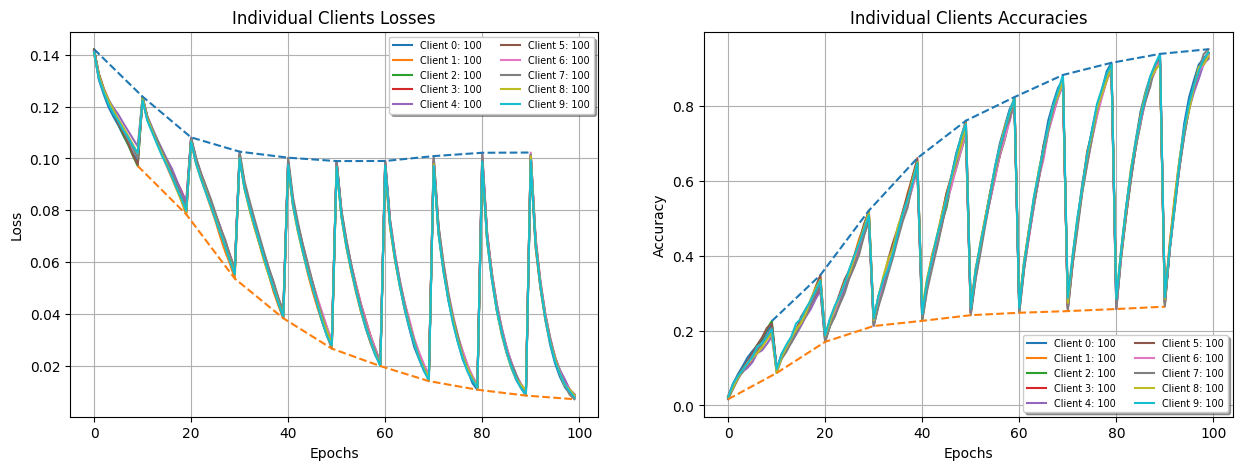

In [23]:
plot_metricss(strategy_fed_avg.client_metrics)

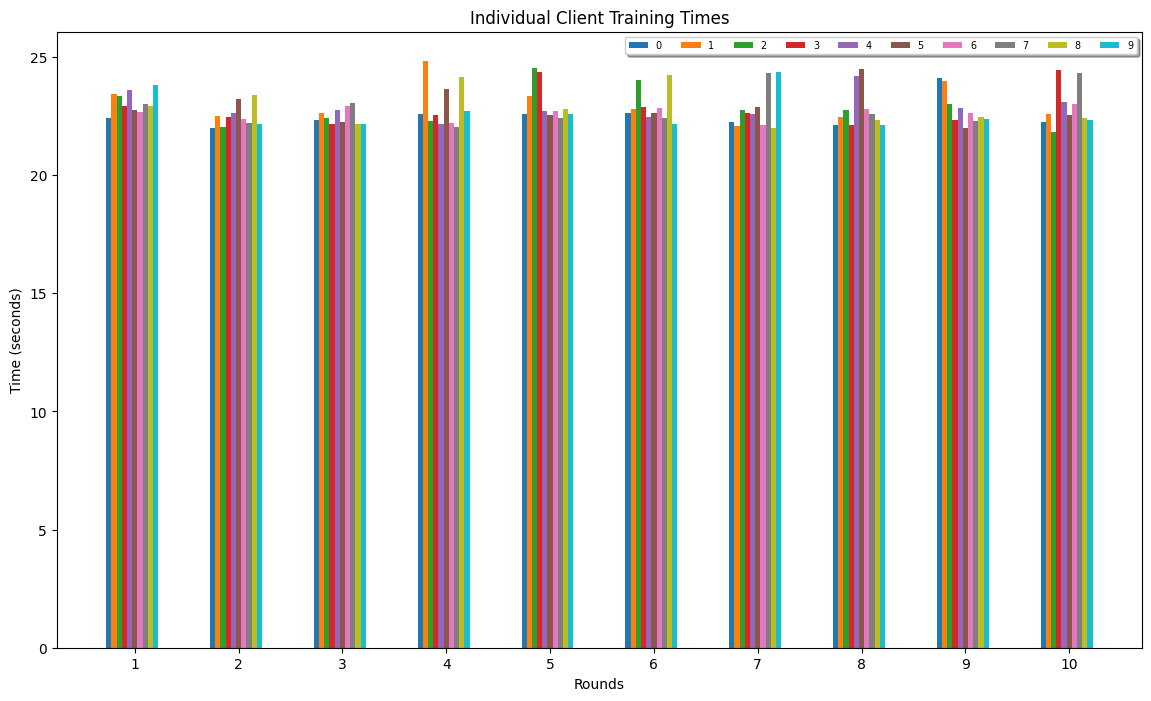

In [19]:
plot_times(strategy_fed_avg.client_training_times)

In [15]:
class FedProxCustom(fl.server.strategy.FedProx):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
        proximal_mu=1.0,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients,proximal_mu=proximal_mu)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [16]:
#strategy_fed_avg = FedAvgCustom()
#strategy_fed_prox = fl.server.strategy.FedProx(proximal_mu=1.0)
strategy_fed_prox = FedProxCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy= strategy_fed_prox,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-12-06 14:58:19,093	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 32113677926.0, 'accelerator_type:RTX': 1.0, 'memory': 64931915162.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56504) [Client 6] get_parameters
(ClientAppActor pid=56504) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56504) Epoch 0: train loss 0.142263, accuracy 0.017556
(ClientAppActor pid=56504) Epoch 1: train loss 0.132821, accuracy 0.048000
(ClientAppActor pid=56484) [Client 4] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56504) Epoch 2: train loss 0.126524, accuracy 0.079111
(ClientAppActor pid=56444) [Client 2] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56484) Epoch 0: train loss 0.143782, accuracy 0.013778
(ClientAppActor pid=56336) [Client 6] fit, config: {'proximal_mu': 1.0} [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=56464) Epoch 1: train loss 0.132482, accuracy 0.047778 [repeated 10x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56484) Epoch 9: train loss 0.095373, accuracy 0.236000 [repeated 3x across cluster]
(ClientAppActor pid=56484) [Client 0] evaluate, config: {}
(ClientAppActor pid=56484) Client 0 loss 0.14199434089660645
(ClientAppActor pid=56484) Client 0 accuracy 0.042
(ClientAppActor pid=56484) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56484) Client 4 loss 0.1415787229537964 [repeated 4x across cluster]
(ClientAppActor pid=56484) Client 4 accuracy 0.04 [repeated 4x across cluster]
(ClientAppActor pid=56444) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56464) Client 7 loss 0.1419773416519165 [repeated 3x across cluster]
(ClientAppActor pid=56464) Client 7 accuracy 0.032 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56392) [Client 9] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56392) Epoch 0: train loss 0.123947, accuracy 0.094889
(ClientAppActor pid=56392) [Client 5] evaluate, config: {}
(ClientAppActor pid=56392) Client 5 loss 0.14289921283721924 [repeated 2x across cluster]
(ClientAppActor pid=56392) Client 5 accuracy 0.056 [repeated 2x across cluster]
(ClientAppActor pid=56372) [Client 6] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=56464) Epoch 1: train loss 0.114861, accuracy 0.137778 [repeated 9x across cluster]
(ClientAppActor pid=56424) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=56372) Epoch 3: train loss 0.105309, accuracy 0.185556 [repeated 21x across cluster]
(ClientAppActor pid=56464) Epoch 6: train loss 0.089999, accuracy 0.260222 [repeated 18x across cluster]
(ClientAppActor pid=56504) Epoch 7: train loss 0.085454, accuracy 0.297778 [repeated 18x across cluster]
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56444) Epoch 9: train loss 0.076379, accuracy 0.355778 [repeated 5x across cluster]
(ClientAppActor pid=56444) [Client 3] evaluate, config: {}
(ClientAppActor pid=56444) Client 3 loss 0.10799903917312623
(ClientAppActor pid=56444) Client 3 accuracy 0.196
(ClientAppActor pid=56444) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56392) Client 2 loss 0.10860271835327148 [repeated 3x across cluster]
(ClientAppActor pid=56392) Client 2 accuracy 0.182 [repeated 3x across cluster]
(ClientAppActor pid=56504) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56372) Client 1 loss 0.10694225597381592 [repeated 4x across cluster]
(ClientAppActor pid=56372) Client 1 accuracy 0.2 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56372) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56372) [Client 4] evaluate, config: {}
(ClientAppActor pid=56372) Client 4 loss 0.11459234189987183 [repeated 2x across cluster]
(ClientAppActor pid=56372) Client 4 accuracy 0.166 [repeated 2x across cluster]
(ClientAppActor pid=56372) Epoch 0: train loss 0.104878, accuracy 0.195333
(ClientAppActor pid=56444) [Client 3] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=56444) Epoch 0: train loss 0.106060, accuracy 0.184667 [repeated 8x across cluster]
(ClientAppActor pid=56484) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=56464) Epoch 2: train loss 0.091144, accuracy 0.257111 [repeated 23x across cluster]
(ClientAppActor pid=56424) Epoch 5: train loss 0.073619, accuracy 0.378889 [repeated 18x across cluster]
(ClientAppActor pid=56372) [Client 0] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56424) Epoch 7: 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56392) Epoch 9: train loss 0.053293, accuracy 0.530889 [repeated 5x across cluster]
(ClientAppActor pid=56392) [Client 4] evaluate, config: {}
(ClientAppActor pid=56392) Client 4 loss 0.11999877214431763
(ClientAppActor pid=56392) Client 4 accuracy 0.196
(ClientAppActor pid=56424) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56424) Client 9 loss 0.11737513113021851 [repeated 4x across cluster]
(ClientAppActor pid=56424) Client 9 accuracy 0.202 [repeated 4x across cluster]
(ClientAppActor pid=56392) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56392) Client 0 loss 0.10995346975326538 [repeated 4x across cluster]
(ClientAppActor pid=56392) Client 0 accuracy 0.26 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56372) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56372) [Client 8] evaluate, config: {}
(ClientAppActor pid=56372) Client 8 loss 0.11378447294235229
(ClientAppActor pid=56372) Client 8 accuracy 0.216
(ClientAppActor pid=56372) Epoch 0: train loss 0.099525, accuracy 0.228889
(ClientAppActor pid=56504) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 5x across cluster]
(ClientAppActor pid=56504) Epoch 0: train loss 0.101764, accuracy 0.219778 [repeated 11x across cluster]
(ClientAppActor pid=56444) [Client 9] fit, config: {'proximal_mu': 1.0} [repeated 2x across cluster]
(ClientAppActor pid=56392) Epoch 5: train loss 0.059003, accuracy 0.484000 [repeated 21x across cluster]
(ClientAppActor pid=56424) Epoch 6: train loss 0.053502, accuracy 0.528444 [repeated 17x across cluster]
(ClientAppActor pid=56372) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56392) Epoch 9: train loss 0.035939, accuracy 0.663111 [repeated 15x acro

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56392) Epoch 9: train loss 0.034662, accuracy 0.688667 [repeated 5x across cluster]
(ClientAppActor pid=56392) [Client 9] evaluate, config: {}
(ClientAppActor pid=56392) Client 9 loss 0.1298002233505249
(ClientAppActor pid=56392) Client 9 accuracy 0.212
(ClientAppActor pid=56504) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56504) Client 5 loss 0.11905490016937256 [repeated 4x across cluster]
(ClientAppActor pid=56504) Client 5 accuracy 0.254 [repeated 4x across cluster]
(ClientAppActor pid=56392) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56444) [Client 7] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56444) Client 3 loss 0.12411385345458985 [repeated 5x across cluster]
(ClientAppActor pid=56444) Client 3 accuracy 0.222 [repeated 5x across cluster]
(ClientAppActor pid=56444) [Client 3] evaluate, config: {}
(ClientAppActor pid=56444) Epoch 0: train loss 0.099377, accuracy 0.228667
(ClientAppActor pid=56484) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=56464) Epoch 1: train loss 0.082767, accuracy 0.317556 [repeated 9x across cluster]
(ClientAppActor pid=56372) [Client 3] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=56392) Epoch 4: train loss 0.056242, accuracy 0.498000 [repeated 21x across cluster]
(ClientAppActor pid=56464) Epoch 6: train loss 0.042339, accuracy 0.628444 [repeated 18x across cluster]
(ClientAppActor pid=56444) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56424) Epoch 9: 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56424) Epoch 9: train loss 0.024466, accuracy 0.780444 [repeated 5x across cluster]
(ClientAppActor pid=56424) [Client 1] evaluate, config: {}
(ClientAppActor pid=56424) Client 1 loss 0.13134145021438598
(ClientAppActor pid=56424) Client 1 accuracy 0.244
(ClientAppActor pid=56504) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56372) Client 8 loss 0.13906263065338134 [repeated 3x across cluster]
(ClientAppActor pid=56372) Client 8 accuracy 0.222 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56444) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=56392) Client 9 loss 0.1442913007736206 [repeated 5x across cluster]
(ClientAppActor pid=56392) Client 9 accuracy 0.196 [repeated 5x across cluster]
(ClientAppActor pid=56444) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56444) Epoch 0: train loss 0.098704, accuracy 0.251111
(ClientAppActor pid=56444) Client 0 loss 0.13208066606521607
(ClientAppActor pid=56444) Client 0 accuracy 0.25
(ClientAppActor pid=56336) [Client 1] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=56504) Epoch 1: train loss 0.076877, accuracy 0.368222 [repeated 9x across cluster]
(ClientAppActor pid=56424) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=56372) Epoch 2: train loss 0.066622, accuracy 0.425111 [repeated 22x across cluster]
(ClientAppActor pid=56484) Epoch 5: train loss 0.041158, accuracy 0.635111

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56392) Epoch 9: train loss 0.020040, accuracy 0.819111 [repeated 5x across cluster]
(ClientAppActor pid=56392) [Client 0] evaluate, config: {}
(ClientAppActor pid=56392) Client 0 loss 0.14363670110702514
(ClientAppActor pid=56392) Client 0 accuracy 0.242
(ClientAppActor pid=56484) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56372) Client 9 loss 0.15781465244293214 [repeated 3x across cluster]
(ClientAppActor pid=56372) Client 9 accuracy 0.22 [repeated 3x across cluster]
(ClientAppActor pid=56392) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56464) Client 8 loss 0.15252123498916625 [repeated 4x across cluster]
(ClientAppActor pid=56464) Client 8 accuracy 0.212 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56444) [Client 8] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56444) Epoch 0: train loss 0.097737, accuracy 0.265111
(ClientAppActor pid=56444) [Client 1] evaluate, config: {}
(ClientAppActor pid=56444) Client 1 loss 0.14290918111801149 [repeated 2x across cluster]
(ClientAppActor pid=56444) Client 1 accuracy 0.246 [repeated 2x across cluster]
(ClientAppActor pid=56484) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=56504) Epoch 0: train loss 0.099102, accuracy 0.261778 [repeated 5x across cluster]
(ClientAppActor pid=56424) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=56444) Epoch 5: train loss 0.033095, accuracy 0.702222 [repeated 21x across cluster]
(ClientAppActor pid=56372) Epoch 4: train loss 0.041053, accuracy 0.629556 [repeated 21x across cluster]
(ClientAppActor pid=56444) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56392) Epoch 9: 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56392) Epoch 9: train loss 0.014509, accuracy 0.876444 [repeated 4x across cluster]
(ClientAppActor pid=56392) [Client 1] evaluate, config: {}
(ClientAppActor pid=56392) Client 1 loss 0.15483824682235717
(ClientAppActor pid=56392) Client 1 accuracy 0.238
(ClientAppActor pid=56464) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56372) Client 5 loss 0.1564295868873596 [repeated 3x across cluster]
(ClientAppActor pid=56372) Client 5 accuracy 0.238 [repeated 3x across cluster]
(ClientAppActor pid=56392) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56336) Client 2 loss 0.16337501668930055 [repeated 4x across cluster]
(ClientAppActor pid=56336) Client 2 accuracy 0.25 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56464) [Client 2] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56464) Epoch 0: train loss 0.099037, accuracy 0.264222
(ClientAppActor pid=56464) [Client 7] evaluate, config: {}
(ClientAppActor pid=56464) Client 7 loss 0.15210017490386962 [repeated 2x across cluster]
(ClientAppActor pid=56464) Client 7 accuracy 0.244 [repeated 2x across cluster]
(ClientAppActor pid=56504) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=56336) Epoch 2: train loss 0.057169, accuracy 0.487556 [repeated 9x across cluster]
(ClientAppActor pid=56372) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=56444) Epoch 2: train loss 0.056854, accuracy 0.496000 [repeated 22x across cluster]
(ClientAppActor pid=56336) Epoch 7: train loss 0.018574, accuracy 0.837111 [repeated 18x across cluster]
(ClientAppActor pid=56464) [Client 3] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56336) Epoch 9: 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56336) Epoch 9: train loss 0.012163, accuracy 0.900667 [repeated 4x across cluster]
(ClientAppActor pid=56336) [Client 6] evaluate, config: {}
(ClientAppActor pid=56336) Client 6 loss 0.18082692623138427
(ClientAppActor pid=56336) Client 6 accuracy 0.214
(ClientAppActor pid=56444) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56464) Client 5 loss 0.16831794261932373 [repeated 3x across cluster]
(ClientAppActor pid=56464) Client 5 accuracy 0.236 [repeated 3x across cluster]
(ClientAppActor pid=56336) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56392) Client 7 loss 0.16233547019958497 [repeated 4x across cluster]
(ClientAppActor pid=56392) Client 7 accuracy 0.252 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56444) [Client 5] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56444) [Client 1] evaluate, config: {}
(ClientAppActor pid=56444) Client 1 loss 0.16583338737487793 [repeated 2x across cluster]
(ClientAppActor pid=56444) Client 1 accuracy 0.242 [repeated 2x across cluster]
(ClientAppActor pid=56444) Epoch 0: train loss 0.102438, accuracy 0.262889
(ClientAppActor pid=56424) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=56504) Epoch 2: train loss 0.052104, accuracy 0.534000 [repeated 9x across cluster]
(ClientAppActor pid=56484) [Client 6] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=56464) Epoch 2: train loss 0.053834, accuracy 0.527556 [repeated 21x across cluster]
(ClientAppActor pid=56504) Epoch 7: train loss 0.014005, accuracy 0.882667 [repeated 18x across cluster]
(ClientAppActor pid=56444) [Client 9] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56504) Epoch 9: 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56504) Epoch 9: train loss 0.009568, accuracy 0.925556 [repeated 5x across cluster]
(ClientAppActor pid=56504) [Client 5] evaluate, config: {}
(ClientAppActor pid=56504) Client 5 loss 0.17842614364624024
(ClientAppActor pid=56504) Client 5 accuracy 0.23
(ClientAppActor pid=56372) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56464) Client 2 loss 0.18419032621383666 [repeated 3x across cluster]
(ClientAppActor pid=56464) Client 2 accuracy 0.244 [repeated 3x across cluster]
(ClientAppActor pid=56504) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56336) Client 3 loss 0.19235869026184083 [repeated 4x across cluster]
(ClientAppActor pid=56336) Client 3 accuracy 0.196 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56444) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56444) Epoch 0: train loss 0.100005, accuracy 0.273556
(ClientAppActor pid=56444) [Client 8] evaluate, config: {}
(ClientAppActor pid=56444) Client 8 loss 0.18876278400421143 [repeated 2x across cluster]
(ClientAppActor pid=56444) Client 8 accuracy 0.21 [repeated 2x across cluster]
(ClientAppActor pid=56336) [Client 2] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=56372) Epoch 1: train loss 0.067146, accuracy 0.416889 [repeated 8x across cluster]
(ClientAppActor pid=56464) [Client 3] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=56372) Epoch 4: train loss 0.029408, accuracy 0.725778 [repeated 21x across cluster]
(ClientAppActor pid=56336) Epoch 5: train loss 0.022147, accuracy 0.804667 [repeated 18x across cluster]
(ClientAppActor pid=56444) [Client 4] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=56504) Epoch 9: t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=56504) Epoch 9: train loss 0.009411, accuracy 0.923778 [repeated 5x across cluster]
(ClientAppActor pid=56504) [Client 0] evaluate, config: {}
(ClientAppActor pid=56504) Client 0 loss 0.18244284725189208
(ClientAppActor pid=56504) Client 0 accuracy 0.238
(ClientAppActor pid=56392) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56424) Client 3 loss 0.20053922462463378 [repeated 3x across cluster]
(ClientAppActor pid=56424) Client 3 accuracy 0.19 [repeated 3x across cluster]
(ClientAppActor pid=56504) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=56372) Client 6 loss 0.19855234909057617 [repeated 4x across cluster]
(ClientAppActor pid=56372) Client 6 accuracy 0.214 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 628.44s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.14207753219604494
INFO :      		round 2: 0.10973414478302002
INFO :      		round 3: 0.11342578563690187
INFO :      		round 4: 0.12400879831314086
INFO :      		round 5: 0.13794562878608702
INFO :      		round 6: 0.150493075466156
INFO :      		round 7: 0.16357551989555358
INFO :      		round 8: 0.17544051847457887
INFO :      		round 9: 0.18461446933746337
INFO :      		round 10: 0.19259723711013793
INFO :      


History (loss, distributed):
	round 1: 0.14207753219604494
	round 2: 0.10973414478302002
	round 3: 0.11342578563690187
	round 4: 0.12400879831314086
	round 5: 0.13794562878608702
	round 6: 0.150493075466156
	round 7: 0.16357551989555358
	round 8: 0.17544051847457887
	round 9: 0.18461446933746337
	round 10: 0.19259723711013793

In [17]:
import matplotlib.pyplot as plt


def plot_metricss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy_fed_prox.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True,)
    axs[1].grid()

    plt.show()

#plot_metrics(strategy.client_metrics)

(ClientAppActor pid=56392) Client 8 loss 0.19670398139953613
(ClientAppActor pid=56392) Client 8 accuracy 0.208


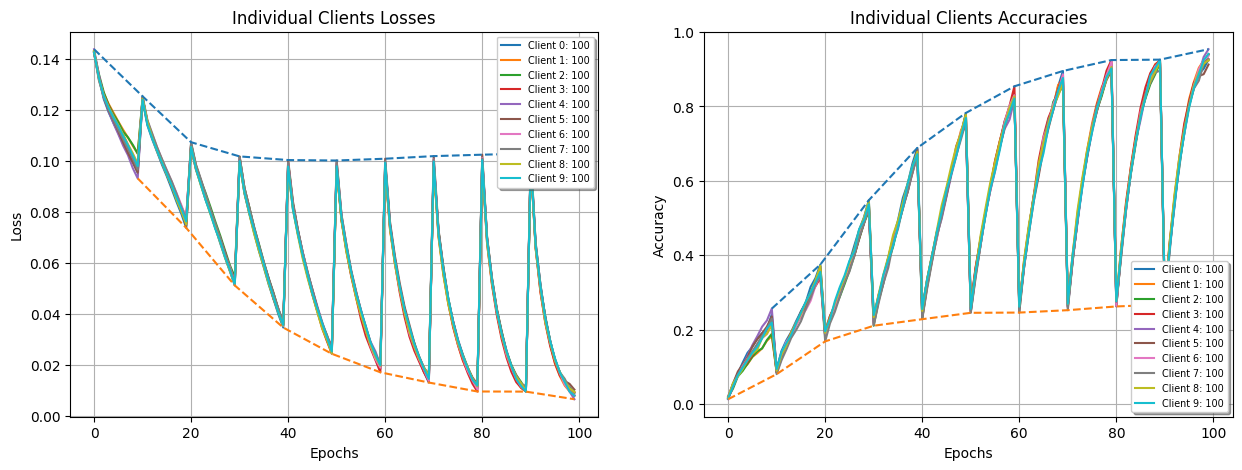

In [18]:
plot_metricss(strategy_fed_prox.client_metrics)


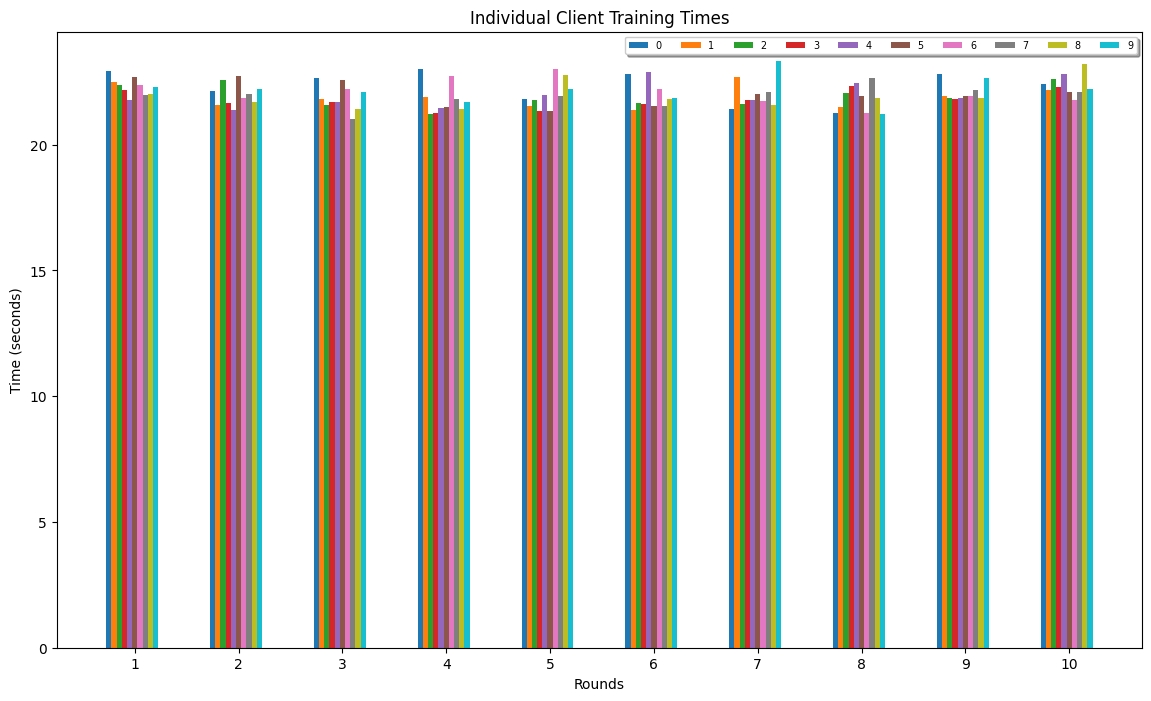

In [19]:
plot_times(strategy_fed_prox.client_training_times)